<a href="https://colab.research.google.com/github/raeubaen/ml/blob/master/codice_bpm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np # allows vectorized operations
import cupy as cp # fork of numpy
# allows vectorized operations on GPU
import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation
# plot style parameters
plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = '#f7f9fc'

Prima di tutto definiamo delle funzioni di plot.

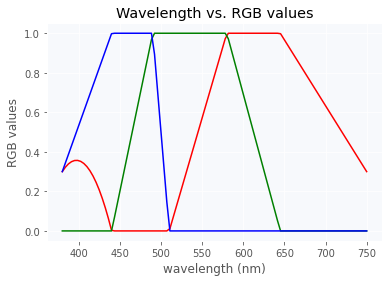

In [43]:
from matplotlib.colors import LinearSegmentedColormap
'''
To make more realistic plots we define a function
returning approzimated colormap from wavelength.
There is not a simple form for it, because of the
complex mechanisms of human vision and trichromy.
The physical model of colors mixing is achieved 
by summing values in RGB and clipping the results at 1.
'''
def wavelength_to_rgb(
    wavelength, #input in meters
    gpu=True,
    ):
    wavelength = wavelength*1e9 # nm
    '''
    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    Additionally alpha value set to 0.5 outside range
    '''
    wl = float(wavelength)
    if wl < 380: wl = 380
    if wl > 750: wl = 750
    if wl >= 380 and wl <= 440:
        att = 0.3 + 0.7 * (wl - 380) / (440 - 380) # attenuation
        R, G, B = ((-(wl - 440) / (440 - 380)) * att), 0, (1.0 * att)
    elif wl >= 440 and wl <= 490:
        R, G, B = 0.0, ((wl - 440) / (490 - 440)), 1
    elif wl >= 490 and wl <= 510:
        R, G, B = 0.0, 1, (-(wl - 510) / (510 - 490))
    elif wl >= 510 and wl <= 580:
        R, G, B = ((wl - 510) / (580 - 510)), 1, 0
    elif wl >= 580 and wl <= 645:
        R, G, B = 1.0, (-(wl - 645) / (645 - 580)), 0
    elif wl >= 645 and wl <= 750:
        att = 0.3 + 0.7 * (750 - wl) / (750 - 645)
        R, G, B = (1.0 * att), 0, 0
    else:
        R, G, B = 0, 0, 0
    if gpu:
        return cp.asarray([R, G, B])
    else:
        return np.asarray([R, G, B])

wavelengths = np.linspace(380, 750, 100)*1e-9 # in meters
rgbs = np.stack([wavelength_to_rgb(wl, gpu=False) for wl in wavelengths])
plt.plot(1e9*wavelengths, rgbs[:, 0], "r-")
plt.plot(1e9*wavelengths, rgbs[:, 1], "g-")
plt.plot(1e9*wavelengths, rgbs[:, 2], "b-")
plt.xlabel("wavelength (nm)")
plt.ylabel("RGB values")
plt.title("Wavelength vs. RGB values")
plt.savefig("wl-rgb.pdf")
plt.show()


In [0]:
def wavelength_to_cmap(wavelength):
  R, G, B = wavelength_to_rgb(wavelength)
  cdict = {
        'red':  [[0.0,  0.0, 0.0],
                  [1.0,  R, R]],
        'green': [[0.0,  0.0, 0.0],
                  [1.0,  G, G]],
        'blue':  [[0.0,  0.0, 0.0],
                  [1.0,  B, B]]
            }
  return LinearSegmentedColormap('Cmap', segmentdata=cdict, N=256)
# default colormap is black screen with red light - similar to lab situation
default_wavelength = 651*1e-9 # meters
default_cmap = wavelength_to_cmap(default_wavelength)

In [0]:
# we define a function to plot 
def plot(Power, 
         figsize=(15, 15), width=15, unit="mm", cmap=default_cmap, 
         fig=None, ax=None
):
  if type(Power)==cp.core.core.ndarray:
    Power = cp.asnumpy(Power)
  if fig is None:
    fig, ax = plt.subplots(figsize=figsize)
  ax.grid(False)
  ax.set(xlabel=f"x ({unit})", ylabel=f"y ({unit})")
  im = ax.imshow(Power, 
      cmap=cmap, extent=[-width,width,-width,width], vmin=0, animated=True)
  return fig, ax, im

In [0]:
def save_animation(arrays, filename):
  ims = []
  fig, ax = plt.subplots(figsize=(15, 15))
  for n in range(arrays.shape[0]):
      fig, ax, im = plot(arrays[n], fig=fig, ax=ax)
      ims.append([im])

  ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                  repeat_delay=1000)

  Writer = animation.writers['ffmpeg']
  writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
  ani.save(filename, writer=writer)
  del ims
  plt.close()

Definiamo a questo punto le funzioni per propagare.

In [0]:
fft1, ifft1 = np.fft.fft, np.fft.ifft # cpu fft when in 1D
fft2, ifft2 = cp.fft.fft2, cp.fft.ifft2 # gpu fft when in 2D

In [0]:
def propagate(Field, k, grid_setup=None, keep_memory=False, threshold=1e-14):
  # k_square_grid is KX**2 + KY**2 in 2D and kx**2 in 1D
  nstepx, nstepz, deltaz, k_square_grid = grid_setup
  # establish which numerical lib to use
  if Field.ndim == 1:
    ncp = np
    fft, ifft = fft1, ifft1
    fmm_shape = (nstepx, nstepz+1)
  elif Field.ndim == 2:
    ncp = cp
    fft, ifft = fft2, ifft2
    fmm_shape = (nstepx, nstepx, nstepz+1)
  if keep_memory:
    # keeps a record of field module at every step
    FieldModuleMemory = ncp.zeros(shape=fmm_shape)
    FieldModuleMemory[..., 0] = ncp.abs(InputField)

  ArgumentOfPropagator  = ((k*n0)**(-1)*(KX**2+KY**2))*(deltaz/2);             
  Propagator = ncp.exp(1j*ArgumentOfPropagator)
  InputPower = ncp.abs(Field)**2

  tstart = time.time()
  for step in range(nstepz):
      Field = ifft(fft(Field)*Propagator)
      if keep_memory:
        FieldModuleMemory[..., 1+step] = cp.abs(Field)
  print(f"Lasted {time.time()-tstart} seconds")

  OutputPower = np.abs(Field)**2
  OutputTotalPower = np.sum(OutputPower) # total power on output plane
  InputTotalPower = np.sum(InputPower) # total power on input plane
  gap = (OutputTotalPower-InputTotalPower)/(OutputTotalPower+InputTotalPower)
  if gap > threshold:
    raise ValueError("Energy not conserved")

  if keep_memory:
      return Field, FieldModuleMemory
  else:
      return Field

In [0]:
def propagate_and_get_rgb(InputField, wavelength, grid=None):
  k = 2*np.pi/(wavelength)
  OutputField = propagate(InputField, k, grid)
  ncp = (np, cp)[InputField.ndim > 1]
  P = ncp.abs(OutputField)**2
  rgb = ncp.stack((P,)*3, axis=-1)/ncp.max(P)
  return rgb*wavelength_to_rgb(wavelength)

# Fascio Gaussiano 2D

In [0]:
################### Physical Parameters  ########################
Ip = 4**2; # peak intensity               
Ib = 1.0; # background illumination                       
Lambda = 0.651e-6; # wavelength of red light
k0 = 2*np.pi/Lambda; # vacuum wavevector                 
n0 = 1; # background index of refraction      
Lz = 5; # computational length of sample    
Lx = 3e-2; # computational width of sample          
Chirp = -0.0*6*230000.0; # input linear chirp parameter         
h = 0*0.67e-3;
xshift = +h/2; # input position on x axis               
w0 = 0.02*Lx # beam width of gaussian beam parameter


################## Computational Parameters #############
nstepx = 1024; # number of transverse grid points
nstepz = 20; # number of longitudinal propagation steps

deltax = Lx/nstepx;
deltaz = Lz/nstepz; # resolution in the z direction, IMPORTANT
deltaf = 1/Lx; # spatial frequency step

In [0]:
##########################  GENERAL GRID SET-UP  ##########################

z = cp.arange(0, Lz+deltaz, deltaz) # z array            
x = -Lx/2 +(cp.arange(0, nstepx, 1))*deltax; # x array               

X, Y = cp.meshgrid(x,x); # x and y grid

##########################  Dispersive Step Setup #########################
# this is to get rid of fftshifts and the sort

ntx = 0;             
kx = cp.zeros(nstepx)                                          
for nn in range(nstepx):
    ikx = nn - ntx;
    kx[nn] = 2*np.pi*deltaf*ikx;
    if nn + 1 - nstepx/2 == 0 :
      ntx = nstepx;

KX, KY = cp.meshgrid(kx, kx);

grid_setup = (nstepx, nstepz, deltaz, KX**2+KY**2)

In [0]:
####################### INPUT FIELDS DEFINITION  #########################
# gaussian beam
InputField = np.sqrt(Ip)*np.exp(-(X**2+Y**2)/(w0**2));

InputPower = np.abs(InputField)**2

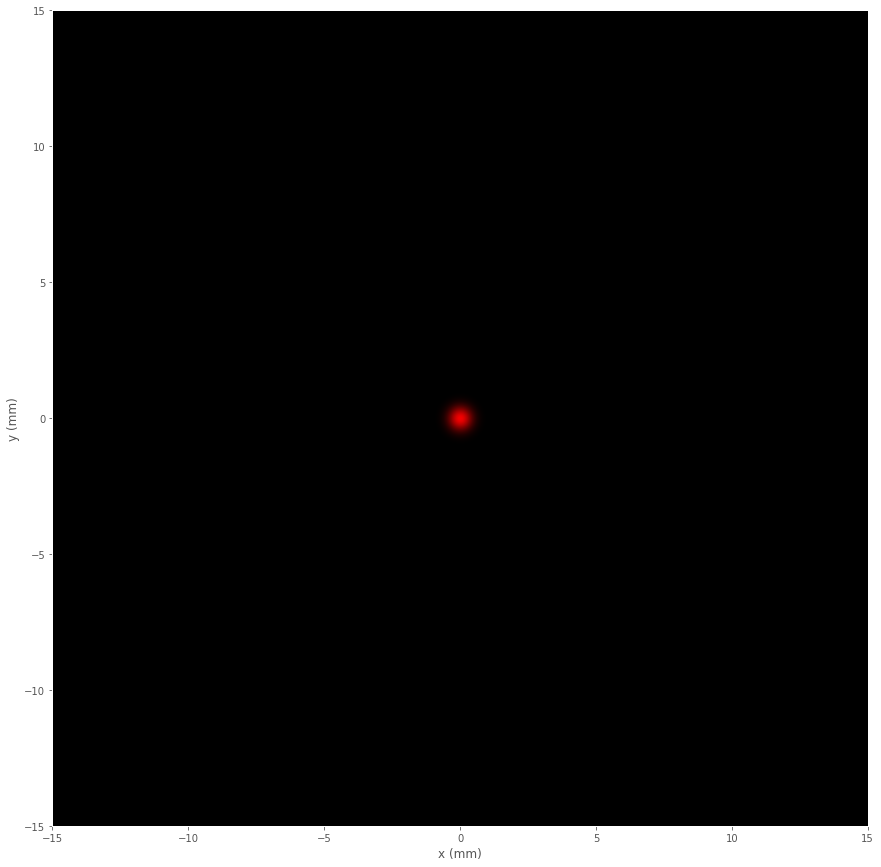

In [72]:
fig, ax, im = plot(InputPower, width=Lx*0.5e3)
fig.savefig("gaussianinputfield.pdf")
plt.show()
plt.close()

Lasted 0.03923630714416504 seconds


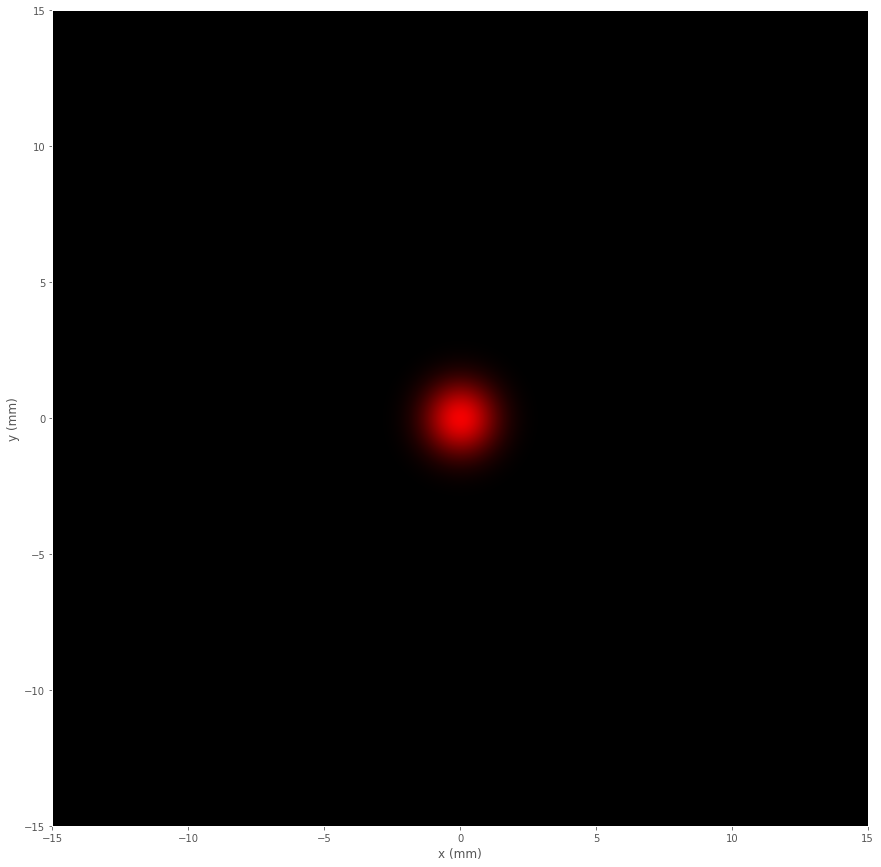

In [67]:
OutputField, FieldModuleMemory = propagate(InputField, k0, 
    grid_setup=grid_setup, keep_memory=True)
OutputPower = np.abs(OutputField)**2
fig, ax, im = plot(OutputPower, width=Lx*0.5e3)
fig.savefig("gaussianoutputfield.pdf")
plt.show()
plt.close()

In [0]:
save_animation(cp.moveaxis(FieldModuleMemory**2, 2, 0), "gaussian_beam.mp4")

Propagation of a red (wider) and a blue (thiner) beam.

Lasted 0.04030251502990723 seconds
Lasted 0.03506159782409668 seconds


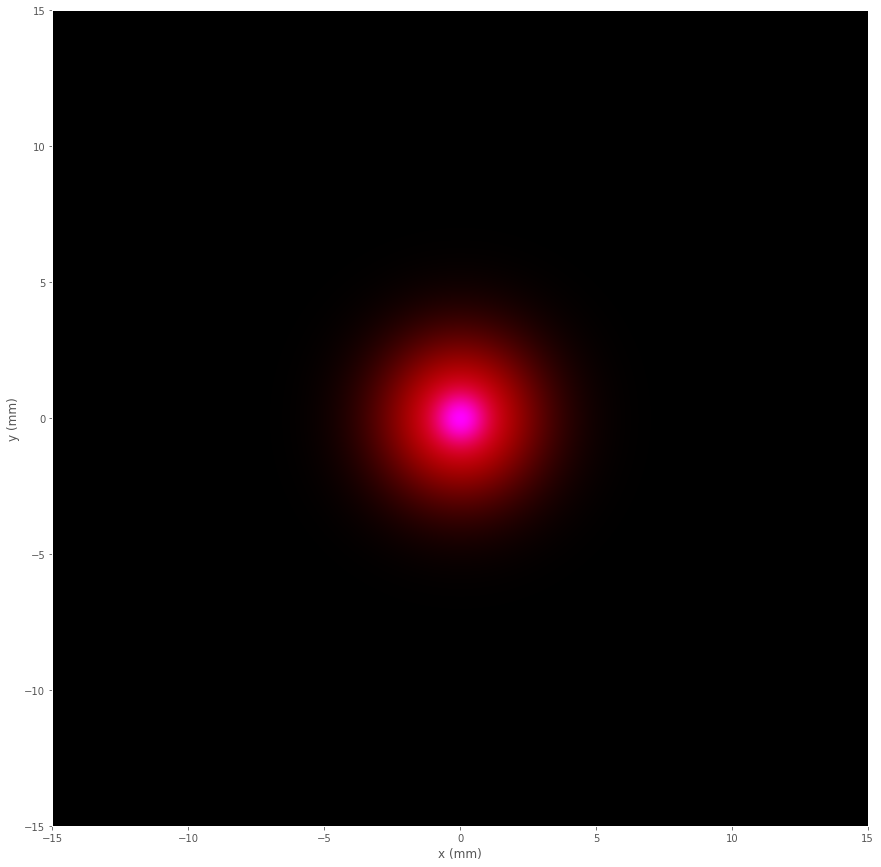

In [94]:
InputField1 = np.sqrt(Ip)*np.exp(-((X)**2+(Y)**2)/(49*w0**2)); #7x larger
InputField2 = np.sqrt(Ip)*np.exp(-((X)**2+(Y)**2)/(w0**2));

RedPower = propagate_and_get_rgb(InputField1, 0.645e-6, grid=grid_setup)
BluePower = propagate_and_get_rgb(InputField, 0.44e-6, grid=grid_setup)
fig, ax, im = plot(RedPower + BluePower) #purple point with red cirle 
# red + blue = purple
fig.savefig("redbluegaussianbeam.pdf")
plt.show()
plt.close()

In [0]:
# we evaluate beam widths (FWHM) as the 2nd moment of a gaussian function

def get_widths(FieldModuleMemory):
  # extends grids X and Y to a third axis
  # in order to make possible multiplying by FieldModuleMemory
  _X = np.stack((X,)*(nstepz+1), axis=-1)
  _Y = np.stack((Y,)*(nstepz+1), axis=-1)

  norms = np.sum(FieldModuleMemory, axis=(0, 1))
  widths = np.sqrt(np.sum((_X**2+_Y**2)*FieldModuleMemory, axis=(0, 1))/norms)
  return widths

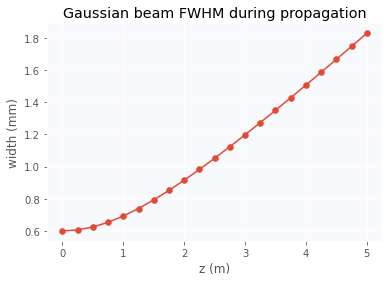

In [100]:
z, widths = cp.asnumpy(z), cp.asnumpy(get_widths(FieldModuleMemory))
plt.scatter(z, 1000*widths)
z0 = k0*w0**2/2 # Rayleigh's width
plt.plot(z, 1000*w0*np.sqrt(1+z**2/z0**2))
plt.xlabel("z (m)")
plt.ylabel("width (mm)")
plt.title("Gaussian beam FWHM during propagation")
plt.savefig("gaussianbeamfwhm.pdf")
plt.show()

# Diffraction Grating